<a href="https://colab.research.google.com/github/ArthurChan-1111/Bitcoin_prediction/blob/main/Master_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages

In [ ]:
!pip install pandas_ta
!pip install numpy==1.23.5
!pip install pandas
!pip install seaborn
!pip install xgboost

In [ ]:
# Importing libraries for data manipulation
import numpy as np
import pandas as pd

# Importing libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries for scaling the data
from sklearn.preprocessing import MinMaxScaler

# Importing libraries for building linear regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import summary_table, OLSInfluence
from statsmodels.regression.linear_model import OLSResults
from statsmodels.stats.stattools import durbin_watson as dwtest
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.stats.diagnostic import het_white

from statsmodels.compat import lzip

import statsmodels.stats.api as sms

from scipy import stats
from scipy.stats import zscore

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score

import pylab as py

# To help with model building
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

# To tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.4f" % x)

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)


#Load dataset

In [ ]:
!git clone https://github.com/ArthurChan-1111/Bitcoin_prediction.git

%cd Bitcoin_prediction

%pip install pandas_ta

import pandas as pd
import pandas_ta as ta
import csv
import numpy as np

btc_data = pd.read_csv('Bitcoin Historical Data.csv', on_bad_lines='skip', lineterminator='\n')
btc_data.tail(5)

Cloning into 'Bitcoin_prediction'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 260 (delta 81), reused 32 (delta 12), pack-reused 119 (from 1)
Receiving objects: 100% (260/260), 20.07 MiB | 19.89 MiB/s, done.
Resolving deltas: 100% (124/124), done.
/content/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction


,Date,Price,Open,High,Low,Vol. ('000),Change %\r
4107,1/5/2014,1014.7000,924.7000,1029.9000,911.4000,21.37,9.74%\r
4108,1/4/2014,924.7000,884.3000,932.2000,848.3000,14.24,4.57%\r
4109,1/3/2014,884.3000,856.9000,888.2000,839.4000,9.71,3.19%\r
4110,1/2/2014,856.9000,815.9000,886.2000,810.5000,12.81,5.02%\r
4111,1/1/2014,815.9000,805.9000,829.9000,771.0000,10.76,1.24%


In [ ]:
# Convert the dictionary to a DataFrame
btc_data = pd.DataFrame(btc_data)

# Parse the "Date" column into datetime format
btc_data["Date"] = pd.to_datetime(btc_data["Date"], format="%m/%d/%Y")

# Sort the data by date in ascending order
btc_data.sort_values(by="Date", ascending=True, inplace=True)


In [ ]:
gold_price_data = pd.read_csv('gold_price_data.csv', on_bad_lines='skip', lineterminator='\n', sep=';')
gold_price_data.tail(5)

,Date,Gold_Price,Gold_Volume
4047,2025-01-30,2794.0600,83835.0000
4048,2025-01-31,2799.2300,91164.0000
4049,2025-02-01,2799.2300,91164.0000
4050,2025-02-02,2799.2300,91164.0000
4051,2025-02-03,2794.4100,1631.0000


In [ ]:
risk_free_data = pd.read_csv('risk_free_data.csv', on_bad_lines='skip', lineterminator='\n', sep=',')
risk_free_data.tail(5)

,Date,US_10Y,Yield_Spread
4126,2025-04-19,4.3400,0.5300
4127,2025-04-20,4.3400,0.5300
4128,2025-04-21,4.4200,0.6700
4129,2025-04-22,4.4100,0.6500
4130,2025-04-23,4.4000,0.5900


In [ ]:
#Change the 'Date' to datetime format
gold_price_data['Date'] = pd.to_datetime(gold_price_data['Date'])
risk_free_data['Date'] = pd.to_datetime(risk_free_data['Date'])

#Data Preprocessing

In [ ]:
#Function to clean and convert volume data
def clean_volume(volume):
    if isinstance(volume, str):  # Check if the value is a string
        volume = volume.replace(',', '')  # Remove commas
        if 'B' in volume:  # If the value contains 'B' (billions)
            return float(volume.replace('B', '')) * 1_000_000_000
        elif 'M' in volume:  # If the value contains 'M' (millions)
            return float(volume.replace('M', '')) * 1_000_000
        elif 'K' in volume:  # If the value contains 'K' (thousands)
            return float(volume.replace('K', '')) * 1_000
        else:  # If no suffix is present, convert to float directly
            return float(volume)
    return np.nan  # Handle unexpected cases

# Apply the cleaning function to the volume column
btc_data["Volume"] = btc_data["Vol. ('000)"].apply(clean_volume)
btc_data = btc_data.drop("Vol. ('000)", axis=1)

# 4. Remove '%' from "Change %" and convert to numeric
btc_data.rename(columns={"Change %\r": "Change"}, inplace=True)
btc_data["Change"] = btc_data["Change"].str.replace("%", "").str.strip().astype(float)

In [ ]:
# Day of the week (0=Monday, 6=Sunday)
btc_data["Day_of_Week"] = btc_data["Date"].dt.dayofweek

# Week of the year
btc_data["Week_of_Year"] = btc_data["Date"].dt.isocalendar().week

# Month of the year
btc_data["Month"] = btc_data["Date"].dt.month

# Quarter of the year
btc_data["Quarter"] = btc_data["Date"].dt.quarter

# Year
btc_data["Year"] = btc_data["Date"].dt.year

## Signal Detection

In [ ]:
# Calculate RSI, EMA, SMA, and MACD
btc_data["RSI_6"] = ta.rsi(btc_data["Price"], length=6)  # Relative Strength Index
btc_data["RSI_12"] = ta.rsi(btc_data["Price"], length=12)  # Relative Strength Index
btc_data["EMA_14"] = ta.ema(btc_data["Price"], length=14)  # Exponential Moving Average
btc_data["SMA_14"] = ta.sma(btc_data["Price"], length=14)  # Simple Moving Average

# Add On-Balance Volume (OBV)
btc_data["OBV"] = ta.obv(btc_data["Price"], btc_data["Volume"])

# Calculate MACD --------------------------------------------------------------------------------------
macd = ta.macd(btc_data["Price"], fast=12, slow=26, signal=9)
btc_data["MACD"] = macd["MACD_12_26_9"]
btc_data["MACD_Signal"] = macd["MACDs_12_26_9"]

# Create MACD_buy: 1 if MACD crosses above MACD_Signal, otherwise 0
btc_data["MACD_buy"] = 0  # Default to 0 (no buy signal)
btc_data.loc[
    (btc_data["MACD"] > btc_data["MACD_Signal"]) &  # MACD is above Signal
    (btc_data["MACD"].shift(1) <= btc_data["MACD_Signal"].shift(1)),  # Previous MACD was below or equal to Signal
    "MACD_buy"] = 1  # Buy signal

# Create MACD_sell: 1 if MACD crosses below MACD_Signal, otherwise 0
btc_data["MACD_sell"] = 0  # Default to 0 (no sell signal)
btc_data.loc[
    (btc_data["MACD"] <= btc_data["MACD_Signal"]) &  # MACD is below or equal to Signal
    (btc_data["MACD"].shift(1) > btc_data["MACD_Signal"].shift(1)),  # Previous MACD was above Signal
    "MACD_sell"] = 1  # Sell signal

# New Variable: MACD_above_signal (1 if MACD > MACD_Signal, otherwise 0)
btc_data["MACD_above_signal"] = (btc_data["MACD"] > btc_data["MACD_Signal"]).astype(int)

# New Variable: MACD_below_signal (1 if MACD <= MACD_Signal, otherwise 0)
btc_data["MACD_below_signal"] = (btc_data["MACD"] <= btc_data["MACD_Signal"]).astype(int)

# Create MACD_cum_buy: Accumulate consecutive days where MACD_above_signal is 1
btc_data["MACD_cum_buy"] = (
    btc_data["MACD_above_signal"]
    .groupby((btc_data["MACD_above_signal"] == 0).cumsum())  # Group by resets when MACD_above_signal is 0
    .cumcount()  # Count consecutive days starting from 1
)
btc_data.loc[btc_data["MACD_above_signal"] == 0, "MACD_cum_buy"] = 0  # Reset to 0 where the condition is not met

# Create MACD_cum_sell: Accumulate consecutive days where MACD_below_signal is 1
btc_data["MACD_cum_sell"] = (
    btc_data["MACD_below_signal"]
    .groupby((btc_data["MACD_below_signal"] == 0).cumsum())  # Group by resets when MACD_below_signal is 0
    .cumcount()  # Count consecutive days starting from 1
)
btc_data.loc[btc_data["MACD_below_signal"] == 0, "MACD_cum_sell"] = 0  # Reset to 0


# Calculate Bollinger Bands --------------------------------------------------------------------------------------
bb = ta.bbands(btc_data["Price"], length=20, std=2)  # 20-period BB with 2 standard deviations
btc_data["BB_upper"] = bb.get("BBU_20_2.0")  # Upper Bollinger Band
btc_data["BB_lower"] = bb.get("BBL_20_2.0")  # Lower Bollinger Band

# Create BB_Buy: 1 if Price crosses below the Lower Band, otherwise 0
btc_data["BB_Buy"] = 0  # Default to 0 (no buy signal)
btc_data.loc[
    (btc_data["Price"] < btc_data["BB_lower"]) &  # Price is below the Lower Band
    (btc_data["Price"].shift(1) >= btc_data["BB_lower"].shift(1)),  # Previous Price was above or equal to Lower Band
    "BB_Buy"] = 1  # Buy signal

# Create BB_Sell: 1 if Price crosses above the Upper Band, otherwise 0
btc_data["BB_Sell"] = 0  # Default to 0 (no sell signal)
btc_data.loc[
    (btc_data["Price"] > btc_data["BB_upper"]) &  # Price is above the Upper Band
    (btc_data["Price"].shift(1) <= btc_data["BB_upper"].shift(1)),  # Previous Price was below or equal to Upper Band
    "BB_Sell"] = 1  # Sell signal

# New Variable: Price_above_lower_band (1 if Price > BB_lower, otherwise 0)
btc_data["Price_below_BB_lower"] = (btc_data["Price"] < btc_data["BB_lower"]).astype(int)

# New Variable: Price_below_upper_band (1 if Price < BB_upper, otherwise 0)
btc_data["Price_above_BB_upper"] = (btc_data["Price"] > btc_data["BB_upper"]).astype(int)

# Create BB_cum_Buy: Accumulate consecutive days where Price_below_BB_lower is 1
btc_data["BB_cum_Buy"] = (
    btc_data["Price_below_BB_lower"]
    .groupby((btc_data["Price_below_BB_lower"] == 0).cumsum())  # Group by resets when Price_below_BB_lower is 0
    .cumcount()  # Count consecutive days starting from 1
)
btc_data.loc[btc_data["Price_below_BB_lower"] == 0, "BB_cum_Buy"] = 0  # Reset to 0 where the condition is not met

# Create BB_cum_Sell: Accumulate consecutive days where Price_above_BB_upper is 1
btc_data["BB_cum_Sell"] = (
    btc_data["Price_above_BB_upper"]
    .groupby((btc_data["Price_above_BB_upper"] == 0).cumsum())  # Group by resets when Price_above_BB_upper is 0
    .cumcount()  # Count consecutive days starting from 1
)
btc_data.loc[btc_data["Price_above_BB_upper"] == 0, "BB_cum_Sell"] = 0  # Reset to 0 where the condition is not met

# Calculate ATR --------------------------------------------------------------------------------------
btc_data["ATR"] = ta.atr(btc_data["High"], btc_data["Low"], btc_data["Price"], length=14)

# Set Stop-Loss Levels (Example with Long Trade)
atr_multiplier = 2
btc_data["Stop_Loss_Long"] = btc_data["Price"] - (btc_data["ATR"] * atr_multiplier) #Stop-Loss for Buy (Long) Trade
btc_data["Stop_Loss_Short"] = btc_data["Price"] + (btc_data["ATR"] * atr_multiplier) #Stop-Loss for Sell (Short) Trade

# Calculate VWAP --------------------------------------------------------------------------------------
btc_data.set_index("Date", inplace=True) # Set the "Date" column as the index
btc_data["VWAP"] = ta.vwap(btc_data["High"], btc_data["Low"], btc_data["Price"], btc_data["Volume"])

# Create VWAP_Buy: 1 if Price crosses above VWAP, otherwise 0
btc_data["VWAP_Buy"] = 0  # Default to 0 (no buy signal)
btc_data.loc[
    (btc_data["Price"] > btc_data["VWAP"]) &  # Price is above VWAP
    (btc_data["Price"].shift(1) <= btc_data["VWAP"].shift(1)),  # Previous Price was below or equal to VWAP
    "VWAP_Buy"] = 1  # Buy signal

# Create VWAP_Sell: 1 if Price crosses below VWAP, otherwise 0
btc_data["VWAP_Sell"] = 0  # Default to 0 (no sell signal)
btc_data.loc[
    (btc_data["Price"] < btc_data["VWAP"]) &  # Price is below VWAP
    (btc_data["Price"].shift(1) >= btc_data["VWAP"].shift(1)),  # Previous Price was above or equal to VWAP
    "VWAP_Sell"] = 1  # Sell signal

## Fear and greed index
#fear_and_greed_index = pd.read_csv('fear_and_greed_index.csv')
## rename the date column in fear_and_greed_index to Date
#fear_and_greed_index.rename(columns={"date": "Date", "value": "Fear_and_Greed_Index"}, inplace=True)
## convert the date column to datetime
#fear_and_greed_index["Date"] = pd.to_datetime(fear_and_greed_index["Date"], format="%Y-%m-%d")
## dropping the timestamp, value_classification, time_until_update columns
#fear_and_greed_index.drop(columns=["timestamp", "value_classification", "time_until_update"], inplace=True)
#fear_and_greed_index.head()

## Join the two dataframes on the "Date" column, dropping
#btc_data = btc_data.merge(fear_and_greed_index, on="Date", how="left")
#btc_data.head(20)

# Support and Resistance Levels
btc_data["Support"] = btc_data["Low"].rolling(window=20).min()  # Lowest low in the past 20 days
btc_data["Resistance"] = btc_data["High"].rolling(window=20).max()  # Highest high in the past 20 days

## Add two columns for extreme fear and extreme greed
#btc_data["Extreme_Fear"] = np.where(btc_data["Fear_and_Greed_Index"] < 0.2, 1, 0)
#btc_data["Extreme_Greed"] = np.where(btc_data["Fear_and_Greed_Index"] > 0.8, 1, 0)
#btc_data.describe().T

# Use 70 in RSI to classify overbought and 30 to classify oversold
btc_data["RSI_12_Oversold"] = np.where(btc_data["RSI_12"] < 30, 1, 0)  # Create RSI_12_Oversold column
btc_data.loc[btc_data["RSI_12_Oversold"] == 0, "Consecutive_RSI_12_Oversold"] = 0  # Reset to 0 where the condition is not met
btc_data["RSI_12_Overbought"] = np.where(btc_data["RSI_12"] > 70, 1, 0)

# Adding RSI_6 greater than RSI_12 to show bullish divergence and conversely
btc_data["RSI_Divergence"] = np.where(btc_data["RSI_6"] > btc_data["RSI_12"], 1, 0)
btc_data.describe().T


## Count consecutive appearances of Extreme_Fear
#btc_data["Consecutive_Extreme_Fear"] = (
#    btc_data["Extreme_Fear"]
#    .groupby((btc_data["Extreme_Fear"] == 0).cumsum())  # Group by resets when Extreme_Fear is 0
#    .cumcount()  # Count consecutive days starting from 1
#btc_data.loc[btc_data["Extreme_Fear"] == 0, "Consecutive_Extreme_Fear"] = 0  # Reset to 0 where the condition is not met

## Count consecutive appearances of Extreme_Greed
#btc_data["Consecutive_Extreme_Greed"] = (
#    btc_data["Extreme_Greed"]
#    .groupby((btc_data["Extreme_Greed"] == 0).cumsum())  # Group by resets when Extreme_Greed is 0
#    .cumcount()  # Count consecutive days starting from 1
#)
#btc_data.loc[btc_data["Extreme_Greed"] == 0, "Consecutive_Extreme_Greed"] = 0  # Reset to 0 where the condition is not met

# Count consecutive appearances of RSI_12_Overbought
btc_data["Consecutive_RSI_12_Overbought"] = (
    btc_data["RSI_12_Overbought"]
    .groupby((btc_data["RSI_12_Overbought"] == 0).cumsum())  # Group by resets when RSI_12_Overbought is 0
    .cumcount()  # Count consecutive days starting from 1
)
btc_data.loc[btc_data["RSI_12_Overbought"] == 0, "Consecutive_RSI_12_Overbought"] = 0  # Reset to 0 where the condition is not met

# Count consecutive appearances of RSI_12_Oversold
btc_data["Consecutive_RSI_12_Oversold"] = (
    btc_data["RSI_12_Oversold"]
    .groupby((btc_data["RSI_12_Oversold"] == 0).cumsum())  # Group by resets when RSI_12_Oversold is 0
    .cumcount()  # Count consecutive days starting from 1
)

In [ ]:
# Calculate the percentage price change over the next 7-day and 2-day (Target Variable for Regression)
btc_data["7D_Pct_Change"] = ((btc_data["Price"].shift(-7) - btc_data["Price"]) / btc_data["Price"]) * 100
btc_data["2D_Pct_Change"] = ((btc_data["Price"].shift(-2) - btc_data["Price"]) / btc_data["Price"]) * 100

# Create binary variables for 7-day and 2-day percentage changes
btc_data["7D_Positive"] = (btc_data["7D_Pct_Change"] > 0).astype(int)  # 1 if positive, 0 if negative
btc_data["2D_Positive"] = (btc_data["2D_Pct_Change"] > 0).astype(int)  # 1 if positive, 0 if negative

## Pattern Detection

In [ ]:
# Asending Triangle
# Sort data by Date
btc_data = btc_data.sort_values('Date')

# Calculate exponential moving average for Resistance_Level
btc_data['Resistance_Level'] = btc_data['High'].ewm(span=7, adjust=False).mean()

# Identify rising trendline (higher lows)
btc_data['Low_Shifted'] = btc_data['Low'].shift(1)
btc_data['Higher_Low'] = (btc_data['Low'] > btc_data['Low_Shifted']).astype(int)

# Detect breakout using rolling mean of Volume
btc_data['Breakout'] = btc_data['Price'] > btc_data['Resistance_Level']

# Add ascending triangle detection signal
btc_data['Ascending_Triangle_Breakout'] = btc_data['Breakout']

# Ensure Breakout is binary (1 or 0)
btc_data['Breakout'] = btc_data['Breakout'].astype(int)

# Ensure Ascending_Triangle_Breakout is binary (1 or 0)
btc_data['Ascending_Triangle_Breakout'] = btc_data['Ascending_Triangle_Breakout'].astype(int)

# Calculate the rolling mean of Volume over 7 days
btc_data['Avg_Volume'] = btc_data['Volume'].rolling(window=7).mean()

# Detect breakout with volume confirmation
btc_data['Breakout_With_Volume'] = ((btc_data['High'] > btc_data['Resistance_Level']) &
                                    (btc_data['Volume'] > btc_data['Avg_Volume'])).astype(int)

# Add ascending triangle detection signal with volume
btc_data['Ascending_Triangle_Breakout_With_Volume'] = btc_data['Breakout_With_Volume']

In [ ]:
# Count the number of breakouts
breakout_count = btc_data['Ascending_Triangle_Breakout_With_Volume'].sum()
print(f"Number of breakouts: {breakout_count}")

Number of breakouts: 1067


In [ ]:
#ADX Pattern (Show the strength of the trend, please only use ADX_Buy_Signal)
!pip install ta
import ta
# Calculate ADX, +DI, and -DI using the ta library
btc_data['ADX'] = ta.trend.adx(btc_data['High'], btc_data['Low'], btc_data['Price'], window=14)
btc_data['+DI'] = ta.trend.adx_pos(btc_data['High'], btc_data['Low'], btc_data['Price'], window=14)
btc_data['-DI'] = ta.trend.adx_neg(btc_data['High'], btc_data['Low'], btc_data['Price'], window=14)

# Define the ADX threshold for a strong trend
adx_threshold = 25

# Generate trade signals
btc_data['ADX_Buy_Signal'] = ((btc_data['ADX'] > adx_threshold) & (btc_data['+DI'] > btc_data['-DI'])).astype(int)
btc_data['ADX_Sell_Signal'] = ((btc_data['ADX'] > adx_threshold) & (btc_data['-DI'] > btc_data['+DI'])).astype(int)

In [ ]:
# Count the number of breakout signals
breakout_count = btc_data['ADX_Buy_Signal'].sum()
print(f"Number of breakout signals: {breakout_count}")

Number of breakout signals: 1377


In [ ]:
#Bullish and Bearish Engulfing
def detect_bullish_engulfing(data):
    return (
        (data['Price'] > data['Open']) &  # Current candle is bullish
        (data['Price'].shift(1) < data['Open'].shift(1)) &  # Previous candle is bearish
        (data['Open'] < data['Price'].shift(1)) &  # Current open is below previous close
        (data['Price'] > data['Open'].shift(1))    # Current close is above previous open
    )

def detect_bearish_engulfing(data):
    return (
        (data['Price'] < data['Open']) &  # Current candle is bearish
        (data['Price'].shift(1) > data['Open'].shift(1)) &  # Previous candle is bullish
        (data['Open'] > data['Price'].shift(1)) &  # Current open is above previous close
        (data['Price'] < data['Open'].shift(1))    # Current close is below previous open
    )

# Apply the detection functions to btc_data
btc_data['Bullish_Engulfing'] = detect_bullish_engulfing(btc_data).astype(int)
btc_data['Bearish_Engulfing'] = detect_bearish_engulfing(btc_data).astype(int)

# Display the rows where patterns are detected
bullish_patterns = btc_data[btc_data['Bullish_Engulfing'] == 1]
bearish_patterns = btc_data[btc_data['Bearish_Engulfing'] == 1]

In [ ]:
breakout_count = btc_data['Bullish_Engulfing'].sum()
print(f"Number of breakout signals: {breakout_count}")

Number of breakout signals: 145


In [ ]:
breakout_count = btc_data['Bearish_Engulfing'].sum()
print(f"Number of breakout signals: {breakout_count}")

Number of breakout signals: 130


##Join External Data Source

In [ ]:
#Left join gold_price_data and risk_free_data to btc_data

btc_data = pd.merge(btc_data, gold_price_data, on='Date', how='left') #till 2025-02-03
btc_data = pd.merge(btc_data, risk_free_data, on='Date', how='left')

#As gold_price and bond yield have market closeure, all na filled by previous day close data

In [ ]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 67 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date                                     4112 non-null   datetime64[ns]
 1   Price                                    4112 non-null   float64       
 2   Open                                     4112 non-null   float64       
 3   High                                     4112 non-null   float64       
 4   Low                                      4112 non-null   float64       
 5   Change                                   4112 non-null   float64       
 6   Volume                                   4112 non-null   float64       
 7   Day_of_Week                              4112 non-null   int32         
 8   Week_of_Year                             4112 non-null   UInt32        
 9   Month                                    

## **Re-scale and Transformation**

**Yeo-Johnson Transformation** for Price, Change, Pct_Change

In [ ]:
# For Price, Change, 7D_Pct_Change, 2D_Pct_Change (use yeo-johnson)
from sklearn.preprocessing import PowerTransformer
import pandas as pd

# Initialize PowerTransformer for each column
power_transformer_price = PowerTransformer(method='yeo-johnson', standardize=False)  # Disable standardization
power_transformer_change = PowerTransformer(method='yeo-johnson', standardize=False)
power_transformer_7d_pct_change = PowerTransformer(method='yeo-johnson', standardize=False)
power_transformer_2d_pct_change = PowerTransformer(method='yeo-johnson', standardize=False)

# Apply the Yeo-Johnson transformation to each column
btc_data['YeoJohnson_Price'] = power_transformer_price.fit_transform(btc_data[['Price']])
btc_data['YeoJohnson_Change'] = power_transformer_change.fit_transform(btc_data[['Change']])
btc_data['YeoJohnson_7D_Pct_Change'] = power_transformer_7d_pct_change.fit_transform(btc_data[['7D_Pct_Change']])
btc_data['YeoJohnson_2D_Pct_Change'] = power_transformer_2d_pct_change.fit_transform(btc_data[['2D_Pct_Change']])

# Store lambda values for each column
lambdas = {
    'Price_lambda': power_transformer_price.lambdas_[0],
    'Change_lambda': power_transformer_change.lambdas_[0],
    '7D_Pct_Change_lambda': power_transformer_7d_pct_change.lambdas_[0],
    '2D_Pct_Change_lambda': power_transformer_2d_pct_change.lambdas_[0]
}

# Calculate mean and standard deviation for each transformed column
transformed_means = {
    'Price_mean': btc_data['YeoJohnson_Price'].mean(),
    'Change_mean': btc_data['YeoJohnson_Change'].mean(),
    '7D_Pct_Change_mean': btc_data['YeoJohnson_7D_Pct_Change'].mean(),
    '2D_Pct_Change_mean': btc_data['YeoJohnson_2D_Pct_Change'].mean()
}

transformed_stds = {
    'Price_std': btc_data['YeoJohnson_Price'].std(),
    'Change_std': btc_data['YeoJohnson_Change'].std(),
    '7D_Pct_Change_std': btc_data['YeoJohnson_7D_Pct_Change'].std(),
    '2D_Pct_Change_std': btc_data['YeoJohnson_2D_Pct_Change'].std()
}

# Print the collected lambdas, means, and standard deviations
print(f"Lambdas: {lambdas}")
print(f"Means: {transformed_means}")
print(f"Standard Deviations: {transformed_stds}")

### Step 2: Back-Transformation ###
# Recreate PowerTransformers with stored lambdas for back-transformation
power_transformer_price.lambdas_ = [lambdas['Price_lambda']]
power_transformer_change.lambdas_ = [lambdas['Change_lambda']]
power_transformer_7d_pct_change.lambdas_ = [lambdas['7D_Pct_Change_lambda']]
power_transformer_2d_pct_change.lambdas_ = [lambdas['2D_Pct_Change_lambda']]

Lambdas: {'Price_lambda': 0.14010275610694164, 'Change_lambda': 0.8205229400088366, '7D_Pct_Change_lambda': 0.8509874190934532, '2D_Pct_Change_lambda': 0.8388272638267407}
Means: {'Price_mean': 17.919095292940135, 'Change_mean': -0.3119563265517425, '7D_Pct_Change_mean': -0.5122816173629563, '2D_Pct_Change_mean': -0.3860026207215605}
Standard Deviations: {'Price_std': 6.273488664045828, 'Change_std': 5.106427645661079, '7D_Pct_Change_std': 12.487698933474627, '2D_Pct_Change_std': 7.115849546299424}


In [ ]:
numerical_variable = btc_data.select_dtypes(include=['number'])
btc_data.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Change', 'Volume',
       'Day_of_Week', 'Week_of_Year', 'Month', 'Quarter', 'Year', 'RSI_6',
       'RSI_12', 'EMA_14', 'SMA_14', 'OBV', 'MACD', 'MACD_Signal', 'MACD_buy',
       'MACD_sell', 'MACD_above_signal', 'MACD_below_signal', 'MACD_cum_buy',
       'MACD_cum_sell', 'BB_upper', 'BB_lower', 'BB_Buy', 'BB_Sell',
       'Price_below_BB_lower', 'Price_above_BB_upper', 'BB_cum_Buy',
       'BB_cum_Sell', 'ATR', 'Stop_Loss_Long', 'Stop_Loss_Short', 'VWAP',
       'VWAP_Buy', 'VWAP_Sell', 'Support', 'Resistance', 'RSI_12_Oversold',
       'Consecutive_RSI_12_Oversold', 'RSI_12_Overbought', 'RSI_Divergence',
       'Consecutive_RSI_12_Overbought', '7D_Pct_Change', '2D_Pct_Change',
       '7D_Positive', '2D_Positive', 'Resistance_Level', 'Low_Shifted',
       'Higher_Low', 'Breakout', 'Ascending_Triangle_Breakout', 'Avg_Volume',
       'Breakout_With_Volume', 'Ascending_Triangle_Breakout_With_Volume',
       'ADX', '+DI', '-DI', 'ADX_Buy_S

**Standardize all numeric variable**

store to scaled_btc_data

In [ ]:
#Standardize all numeric variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize the MinMaxScaler and StandardScaler
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply log transformation to 'Volume' to reduce the range
btc_data['Volume'] = np.log1p(btc_data['Volume'])  # log1p handles log(0) safely

# Apply Scaler
btc_data['Volume'] = min_max_scaler.fit_transform(btc_data[['Volume']])
btc_data['Volume'] = standard_scaler.fit_transform(btc_data[['Volume']])

# List of features for scaling
numeric_features = [
  'Price', 'Open', 'High', 'Low', 'Change', 'RSI_6', 'RSI_12', 'EMA_14',
  'SMA_14', 'OBV', 'MACD', 'MACD_Signal','MACD_above_signal', 'MACD_below_signal','MACD_cum_buy', 'MACD_cum_sell',
  'BB_lower', 'BB_upper','Price_below_BB_lower', 'Price_above_BB_upper', 'BB_cum_Buy', 'BB_cum_Sell',
  'ATR', 'Stop_Loss_Long', 'Stop_Loss_Short', 'VWAP','Support', 'Resistance', 'YeoJohnson_Price',
  'YeoJohnson_Change','YeoJohnson_7D_Pct_Change', 'YeoJohnson_2D_Pct_Change', 'Gold_Price', 'Gold_Volume',
  'US_10Y', 'Yield_Spread']

# Fit and transform only the numeric features
scaled_features = standard_scaler.fit_transform(btc_data[numeric_features])

# Create a new DataFrame for scaled data
scaled_btc_data = btc_data.copy()  # Copy original DataFrame

# Replace numeric columns in the new DataFrame with scaled values
scaled_btc_data[numeric_features] = scaled_features

scaled_btc_data.tail()

,Date,Price,Open,High,Low,Change,Volume,Day_of_Week,Week_of_Year,Month,Quarter,Year,RSI_6,RSI_12,EMA_14,SMA_14,OBV,MACD,MACD_Signal,MACD_buy,MACD_sell,MACD_above_signal,MACD_below_signal,MACD_cum_buy,MACD_cum_sell,BB_upper,BB_lower,BB_Buy,BB_Sell,Price_below_BB_lower,Price_above_BB_upper,BB_cum_Buy,BB_cum_Sell,ATR,Stop_Loss_Long,Stop_Loss_Short,VWAP,VWAP_Buy,VWAP_Sell,Support,Resistance,RSI_12_Oversold,Consecutive_RSI_12_Oversold,RSI_12_Overbought,RSI_Divergence,Consecutive_RSI_12_Overbought,7D_Pct_Change,2D_Pct_Change,7D_Positive,2D_Positive,Resistance_Level,Low_Shifted,Higher_Low,Breakout,Ascending_Triangle_Breakout,Avg_Volume,Breakout_With_Volume,Ascending_Triangle_Breakout_With_Volume,ADX,+DI,-DI,ADX_Buy_Signal,ADX_Sell_Signal,Gold_Price,Gold_Volume,US_10Y,Yield_Spread,YeoJohnson_Price,YeoJohnson_Change,YeoJohnson_7D_Pct_Change,YeoJohnson_2D_Pct_Change
4107,2025-04-01,2.6715,2.5670,2.6141,2.6417,0.4266,-0.3085,1,14,4,2,2025,0.1076,-0.2047,2.6707,2.6876,-1.6044,-0.9832,-1.1642,0,0,0.9651,-0.9497,0.9441,-0.6350,2.5104,2.8520,0,0,-0.2302,-0.3012,-0.1894,-0.2434,1.9599,2.7141,2.6240,2.6427,1,0,2.8802,2.5117,0,0,0,1,0,NaN,-2.3540,0,0,85430.2187,81300.1000,1,0,0,58.1386,1,1,21.9774,17.5643,21.1854,0,0,NaN,NaN,1.5832,-0.4077,1.5881,0.5927,NaN,-0.3181
4108,2025-04-02,2.5632,2.6744,2.7295,2.6385,-0.4897,-0.0269,2,14,4,2,2025,-0.6897,-0.6506,2.6592,2.6749,-1.6044,-1.0604,-1.1542,0,0,0.9651,-0.9497,1.0321,-0.6350,2.5050,2.8648,0,0,-0.2302,-0.3012,-0.1894,-0.2434,2.1356,2.5777,2.5396,2.6448,0,1,2.9207,2.5117,0,0,0,0,0,NaN,1.6258,0,1,86166.9891,82435.8000,0,0,0,64.1400,1,1,20.9233,21.3819,18.5021,0,0,NaN,NaN,1.6121,-0.4205,1.5635,-0.6499,NaN,0.2633
4109,2025-04-03,2.5893,2.5659,2.5498,2.5946,0.0759,-0.1627,3,14,4,2,2025,-0.4565,-0.5219,2.6527,2.6718,-1.6044,-1.0655,-1.1472,0,0,0.9651,-0.9497,1.1201,-0.6350,2.5052,2.8609,0,0,-0.2302,-0.3012,-0.1894,-0.2434,2.0859,2.6112,2.5593,2.5780,1,0,2.9363,2.5117,0,0,0,0,0,NaN,0.4722,0,1,85602.4668,82358.9000,0,0,0,67.9486,0,0,19.5152,20.1941,19.7114,0,0,NaN,NaN,1.4769,-0.3435,1.5695,0.2037,NaN,0.1185
4110,2025-04-04,2.6183,2.5921,2.5818,2.6104,0.0876,-0.1030,4,14,4,2,2025,-0.1944,-0.3766,2.6510,2.6712,-1.6044,-1.0091,-1.1299,0,0,0.9651,-0.9497,1.2081,-0.6350,2.5047,2.8594,0,0,-0.2302,-0.3012,-0.1894,-0.2434,2.0658,2.6450,2.5842,2.6037,0,0,2.9363,2.5117,0,0,0,1,0,NaN,NaN,0,0,85377.8751,81313.8000,1,0,0,68.8471,0,0,18.5176,20.5967,18.4313,0,0,NaN,NaN,1.4286,-0.3692,1.5761,0.2178,NaN,NaN
4111,2025-04-05,2.6054,2.6215,2.5635,2.6396,-0.0922,-0.9038,5,14,4,2,2025,-0.3119,-0.4362,2.6478,2.6704,-1.6044,-0.9771,-1.1092,0,0,0.9651,-0.9497,1.2962,-0.6350,2.5035,2.8652,0,0,-0.2302,-0.3012,-0.1894,-0.2434,1.9757,2.6402,2.5645,2.6027,0,0,2.9363,2.5117,0,0,0,1,0,NaN,NaN,0,0,85095.7313,81691.1000,1,0,0,67.9000,0,0,17.5912,19.7421,17.6665,0,0,NaN,NaN,1.4286,-0.3692,1.5732,-0.0156,NaN,NaN


# **Please use scaled_btc_data for analysis**

In [ ]:
scaled_btc_data.VWAP_Buy.value_counts()

VWAP_Buy
0    3057
1    1055
Name: count, dtype: int64

- missing values
- rolling window counts - how many buy signals in the last 7 days
- Combine Indicators

**Drop NA before Analysis**

In [ ]:
# Drop rows with NaN values in scaled_btc_data
scaled_btc_data = scaled_btc_data.dropna()

# Optionally, reset the index after dropping rows
scaled_btc_data = scaled_btc_data.reset_index(drop=True)

#Exploratory Data Analysis

In [ ]:
# Define target
target = '7D_Pct_Change'

In [ ]:
# Define predictors
pname = [
    'VWAP_Buy', 'VWAP_Sell',
    'MACD_buy', 'MACD_sell',
    'BB_Buy', 'BB_Sell',
    'RSI_12_Oversold', 'RSI_12_Overbought',
    'RSI_Bullish_Divergence', 'RSI_Bearish_Divergence',
    'RSI_6', 'RSI_12', 'MACD', 'MACD_Signal', 'VWAP', 'ATR'
]

##Univariate Analysis

##Bivariate Analysis

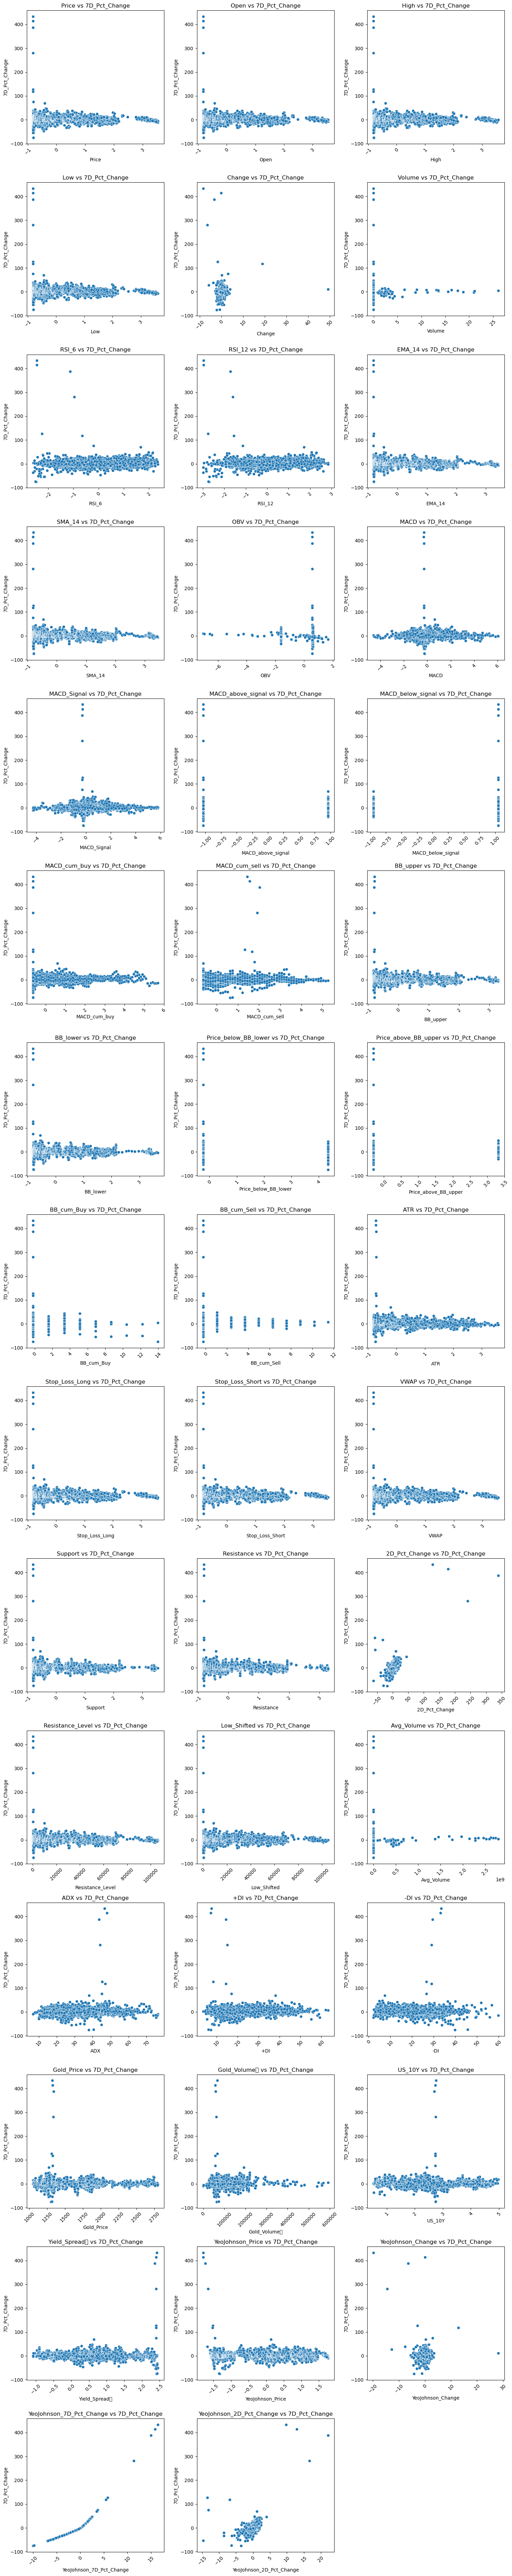

In [ ]:
# Select numeric columns
numeric_variables = scaled_btc_data.select_dtypes(include=['float64']).columns.tolist()

# Identify 2-dimensional columns
for column in numeric_variables:
    if len(scaled_btc_data[column].shape) != 1:  # Check if the column is not 1D
        print(f"Column '{column}' is 2-dimensional with shape {scaled_btc_data[column].shape}")

# Filter out 2D columns and remove target from predictors
numeric_variables = [col for col in numeric_variables if len(scaled_btc_data[col].shape) == 1 and col != target]

# Drop rows with missing values
data_numeric = scaled_btc_data[numeric_variables + [target]].dropna()

# Define number of rows and columns for the subplot grid
n_cols = 3
n_rows = (len(numeric_variables) + n_cols - 1) // n_cols  # Ceiling division

# Create figure with subplots
fig = plt.figure(figsize=(15, 5 * n_rows))

# Create scatter plots
for i, column in enumerate(numeric_variables, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=data_numeric, x=column, y=target, ax=ax)
    ax.set_title(f"{column} vs {target}")
    ax.set_xlabel(column)
    ax.set_ylabel(target)

    # Rotate x-axis labels if they're too long
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

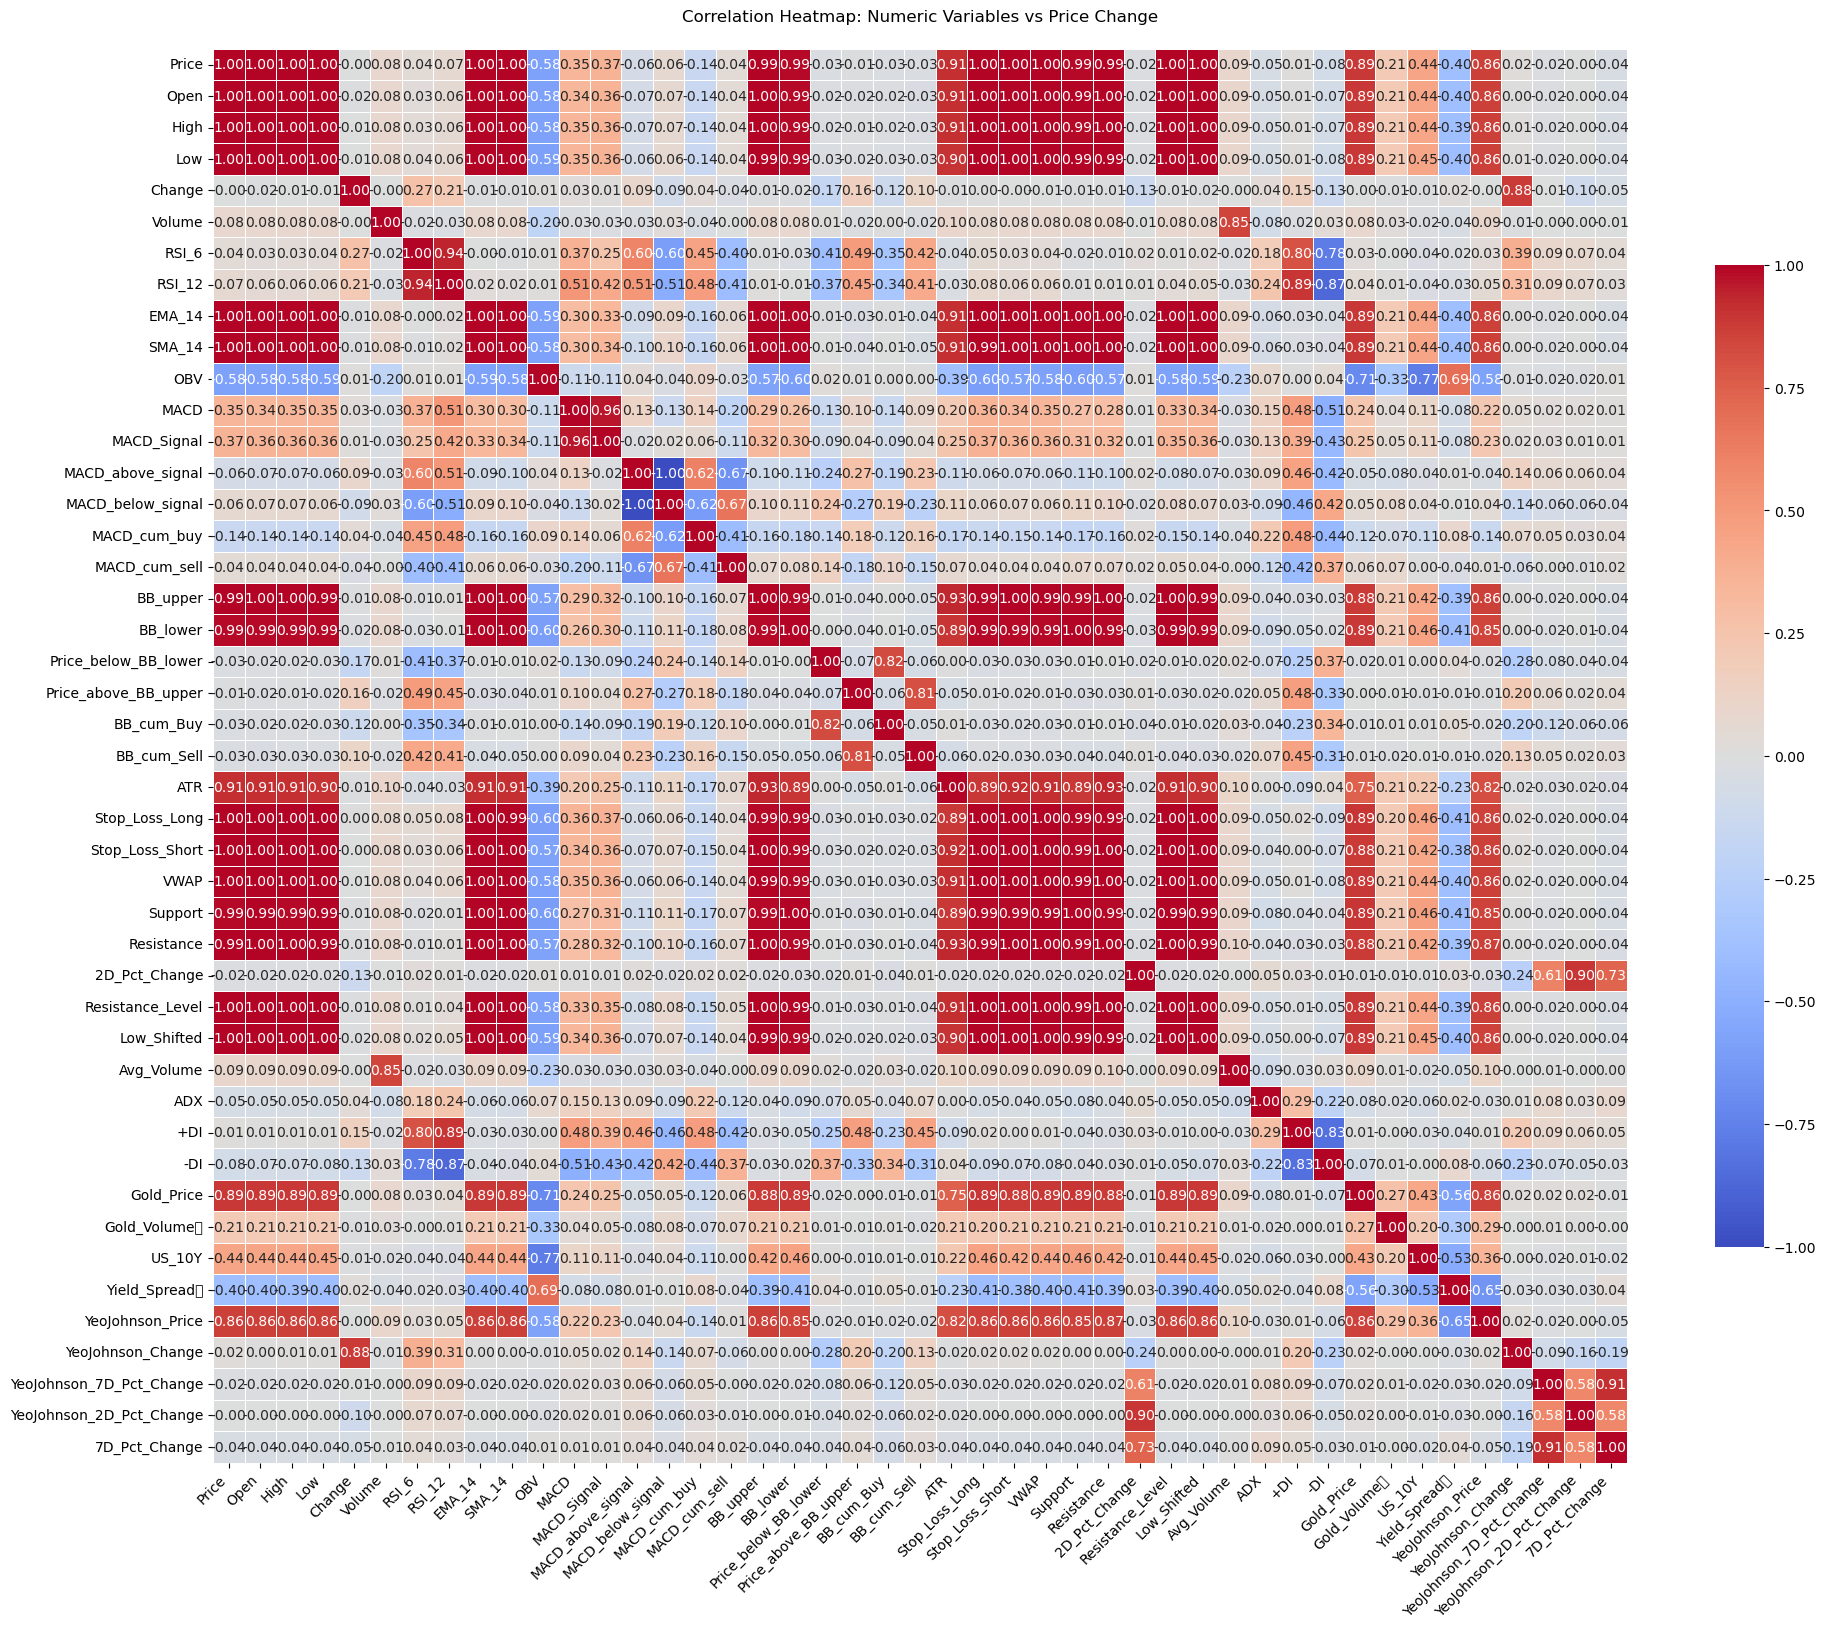

In [ ]:
# Create correlation matrix
correlation_matrix = data_numeric.corr()

plt.figure(figsize=(20, 20))

# Create heatmap with annotations
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap: Numeric Variables vs Price Change', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

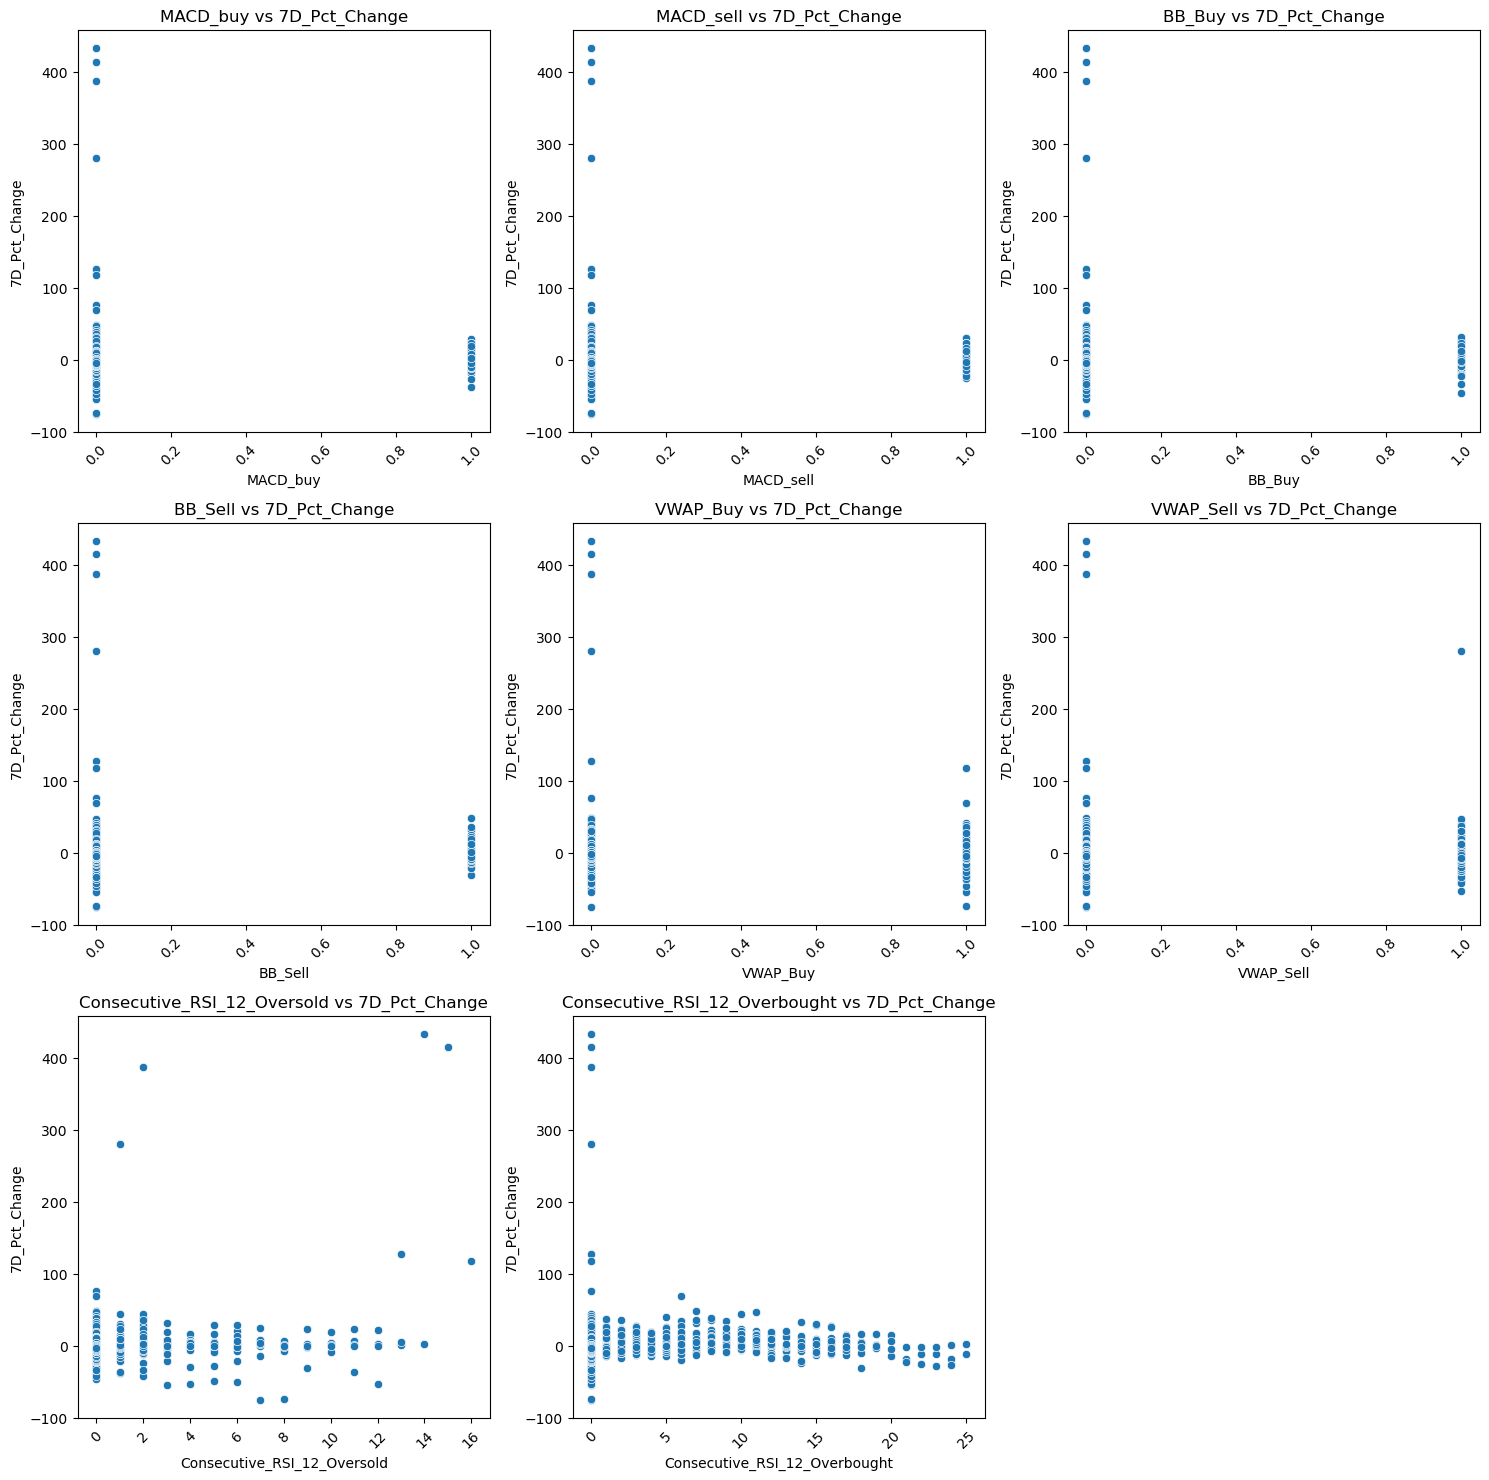

In [ ]:
# Select binary columns
binary_variables = scaled_btc_data.select_dtypes(include=['int64']).columns.tolist()

# Identify 2-dimensional columns
for column in binary_variables:
    if len(scaled_btc_data[column].shape) != 1:  # Check if the column is not 1D
        print(f"Column '{column}' is 2-dimensional with shape {scaled_btc_data[column].shape}")

# Filter out 2D columns and remove target from predictors
binary_variables = [col for col in binary_variables if len(scaled_btc_data[col].shape) == 1 and col != target]

# Drop rows with missing values
data_binary = scaled_btc_data[binary_variables + [target]].dropna()

# Define number of rows and columns for the subplot grid
n_cols = 3
n_rows = (len(binary_variables) + n_cols - 1) // n_cols  # Ceiling division

# Create figure with subplots
fig = plt.figure(figsize=(15, 5 * n_rows))

# Create scatter plots
for i, column in enumerate(binary_variables, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=data_binary, x=column, y=target, ax=ax)
    ax.set_title(f"{column} vs {target}")
    ax.set_xlabel(column)
    ax.set_ylabel(target)

    # Rotate x-axis labels if they're too long
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

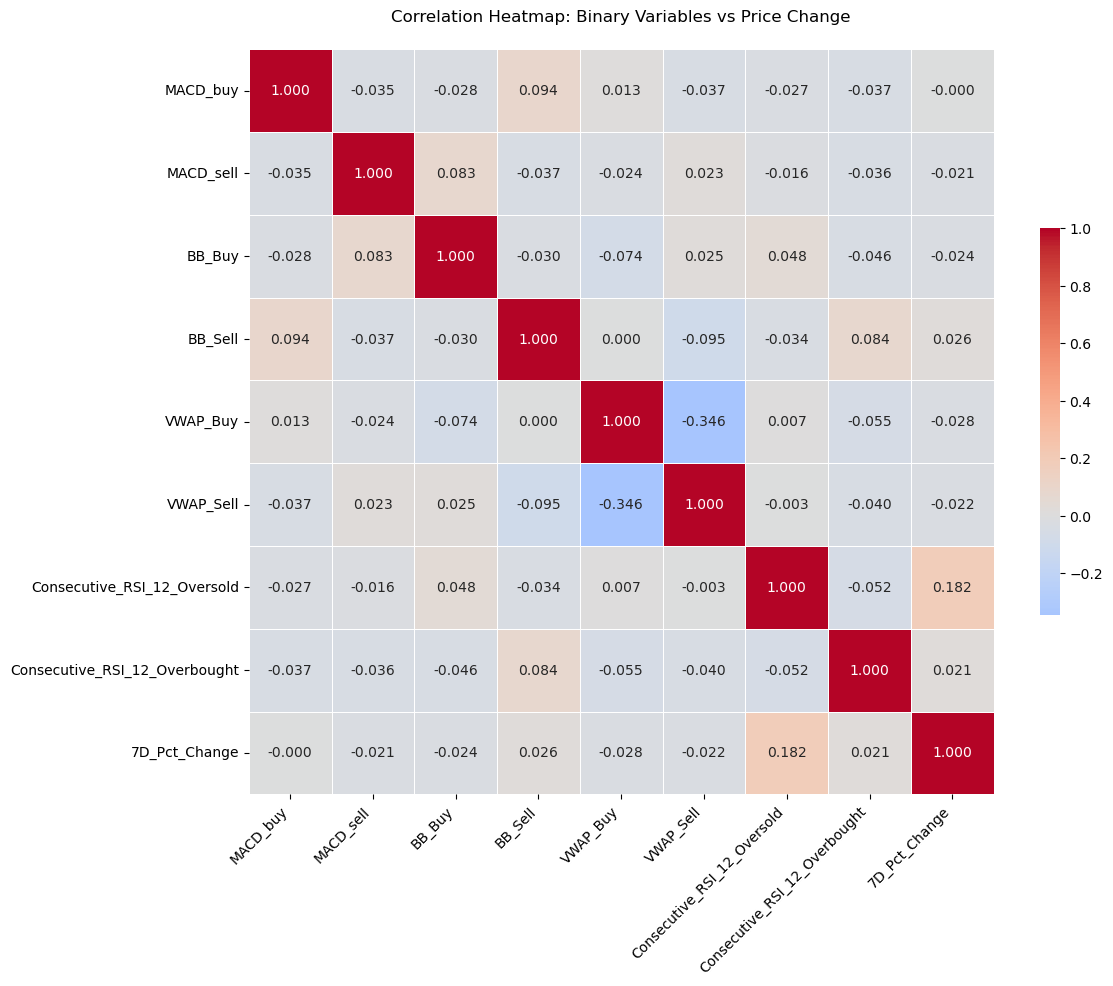

In [ ]:
# Create correlation matrix
correlation_matrix = data_binary.corr()

plt.figure(figsize=(12, 10))

# Create heatmap with annotations
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.3f',
            linewidths=0.5,
            cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap: Binary Variables vs Price Change', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

# Model Building

- Time-Based Splitting
- Selecting predictors
- Interaction terms

In [ ]:
from itertools import chain, combinations

def gen_combinations(input):
    return sum([list(map(list, combinations(input, i))) for i in range(1,len(input) + 1)], [])

def gen_interactions(X,de,pname):
    s = gen_combinations(range(len(pname)))
    VX = []
    VarX = []
    for i in range(len(s)):
        if len(s[i]) <= de:
            VX.append(np.prod(X[:,s[i]],axis=1))
            VarX.append(list([pname[x] for x in s[i]]))
    VarX2 = []
    for x in VarX:
        if len(x) > 1:
            VarX2.append('_'.join(x))
        else:
            VarX2.append(x[0])
    VX = pd.DataFrame(np.array(VX).T,columns=VarX2)
    return VX, VarX2

In [ ]:
# Step 1: Define relevant predictors (skip time-based and unscaled columns)
relevant_predictors = [
    'VWAP_Buy', 'MACD_buy', 'BB_Buy', 'RSI_12_Oversold', 'RSI_Bullish_Divergence',
    'VWAP', 'MACD', 'RSI_6', 'RSI_12', 'ATR'
]

# Step 2: Exclude redundant or invalid combinations
excluded_pairs = [
    ('VWAP_Buy', 'VWAP_Sell'),
    ('MACD_buy', 'MACD_sell'),
    ('BB_Buy', 'BB_Sell')
]

# Step 3: Filter the dataset for only relevant predictors
filtered_data = scaled_btc_data[relevant_predictors].dropna()
X = filtered_data.values  # Extract as numpy array
pname = filtered_data.columns.tolist()  # List of predictor names

# Step 4: Generate interaction terms
interaction_terms, interaction_names = gen_interactions(X, de=2, pname=pname)

# Step 5: Remove excluded interaction terms
valid_interactions = []
valid_names = []

for i, name in enumerate(interaction_names):
    # Split interaction term (e.g., "VWAP_Buy_MACD_buy" -> ["VWAP_Buy", "MACD_buy"])
    components = name.split('_')

    # Check if the pair is in the excluded list
    if len(components) == 2 and tuple(sorted(components)) in excluded_pairs:
        continue  # Skip this interaction term

    # Otherwise, keep it
    valid_interactions.append(interaction_terms.iloc[:, i])
    valid_names.append(name)

# Step 6: Convert valid interactions back to a DataFrame
interaction_df = pd.DataFrame(valid_interactions).T  # Transpose to align rows
interaction_df.columns = valid_names  # Set column names

# Step 7: Append interaction terms to the original dataset
scaled_btc_data_with_interactions = pd.concat([scaled_btc_data, interaction_df], axis=1)

# Display the first few rows of the updated dataset
scaled_btc_data_with_interactions.head()

KeyError: "['RSI_Bullish_Divergence'] not in index"

## Splitting the data into training, testing and validation datasets

In [ ]:
# Splitting data (70% train, 15% validation, 15% test)
train_size = int(len(final_df) * 0.7)
val_size = int(len(final_df) * 0.15)

# Time-based splits
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size : train_size + val_size]
y_val = y.iloc[train_size : train_size + val_size]

X_test = X.iloc[train_size + val_size :]
y_test = y.iloc[train_size + val_size :]

## Defining functions for model performance evaluation

In [ ]:
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())


# MAPE
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100


# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))

# To see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=10):
    if isinstance(model,LinearRegression):
        importances = model.coef_
    else:
        importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))


# Model Performance on test and train data
def model_pref(olsmodel, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = olsmodel.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = olsmodel.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
                "MAPE": [
                    mape(y_pred_train, y_observed_train),
                    mape(y_pred_test, y_observed_test),
                ],
            }
        )
    )

##Model 1: Linear Regression

In [ ]:
predictors = valid_names

# Create the formula for the regression model
formula = f"{target} ~ {' + '.join(predictors)}"

# Fit the OLS regression model
lm_model = smf.ols(formula=formula, data= scaled_btc_data_with_interactions).fit()

# Print the summary of the model
print(lm_model.summary())

                              OLS Regression Results                             
Dep. Variable:     YeoJohnson_Pct_Change   R-squared:                       0.287
Model:                               OLS   Adj. R-squared:                  0.276
Method:                    Least Squares   F-statistic:                     25.53
Date:                   Wed, 23 Apr 2025   Prob (F-statistic):          3.43e-243
Time:                           18:09:28   Log-Likelihood:                -5094.9
No. Observations:                   4062   AIC:                         1.032e+04
Df Residuals:                       3998   BIC:                         1.072e+04
Df Model:                             63                                         
Covariance Type:               nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

### Checking Model Assumptions

Model assumption 1: Mean of residuals should be 0

Model assumption 2: No Heteroscedasticity

Model assumption 3: Linearity

Model assumption 4: Normality of the residuals

###Checking for Autocorrelation

###Checking for Multicollinearity

PCA

Lasso/ Ridge?

##Model 2: ANN

In [ ]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

def ann_lin(x_train, y_train, x_test, y_test,
            size, max_iter=100, trace=False, n_try=5):
    best_train_mse = np.inf
    best_test_mse  = np.inf
    best_train_model = None
    best_test_model  = None

    for i in range(n_try):
        # create a regressor with one hidden layer of 'size' units
        model = MLPRegressor(hidden_layer_sizes=(size,),
                             activation='relu',
                             solver='adam',
                             max_iter=max_iter,
                             random_state=i)

        model.fit(x_train, y_train)

        # compute train MSE
        y_train_pred = model.predict(x_train)
        train_mse = mean_squared_error(y_train, y_train_pred)

        # compute test MSE
        y_test_pred = model.predict(x_test)
        test_mse = mean_squared_error(y_test, y_test_pred)

        if trace:
            print(f"Run {i+1}/{n_try} → train MSE: {train_mse:.4f}, test MSE: {test_mse:.4f}")

        # update best-by-train
        if train_mse < best_train_mse:
            best_train_mse = train_mse
            best_train_model = model

        # update best-by-test
        if test_mse < best_test_mse:
            best_test_mse = test_mse
            best_test_model = model

    return {
        'best_train_mse': best_train_mse,
        'best_test_mse':  best_test_mse,
        'best_train_model': best_train_model,
        'best_test_model':  best_test_model
    }


##Model 3: Random Forest

In [ ]:
# Build random forest model
regressor = RandomForestRegressor(n_estimators=100, random_state=1)
regressor.fit(X_train, y_train)


In [ ]:
# Evaluate on validation set
val_performance = model_performance_regression(regressor, X_val, y_val)
print("Validation performance:", val_performance)

###Model Validation and Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning
rf_tuned = RandomForestRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [110, 120],
    "max_depth": [5, 7],
    "max_features": [0.8, 1]
}

# Use time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring='r2', cv=tscv)
grid_obj.fit(X_train, y_train)

# Get the best model
rf_tuned_regressor = grid_obj.best_estimator_
print("Best parameters:", grid_obj.best_params_)
tuned_val_performance = model_performance_regression(rf_tuned_regressor, X_val, y_val)
print("Tuned model validation performance:", tuned_val_performance)

In [ ]:
# Compare base model vs tuned model on validation
print("\nModel comparison on validation set:")
print(f"Base model R²: {val_performance['R²']:.4f}")
print(f"Tuned model R²: {tuned_val_performance['R²']:.4f}")

In [ ]:
# Train final model on combined training and validation data
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

final_rfmodel = RandomForestRegressor(**grid_obj.best_params_, random_state=1)
final_rfmodel.fit(X_train_val, y_train_val)

In [ ]:
# Final evaluation on test set only once
final_test_performance = model_performance_regression(final_rfmodel, X_test, y_test)
print("\nFinal test performance:", final_test_performance)

##Analyse Feature Importance



In [ ]:
# Plot feature importances
importances = regressor.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#Model Performance Comparison

#Final Model Evaluation and Backtesting

Walk-Forward Validation

## Back Transformation After prediction (for interpretation)

In [ ]:
# Recreate PowerTransformers with stored lambdas for back-transformation
power_transformer_price.lambdas_ = [lambdas['Price_lambda']]
power_transformer_change.lambdas_ = [lambdas['Change_lambda']]
power_transformer_7d_pct_change.lambdas_ = [lambdas['7D_Pct_Change_lambda']]
power_transformer_2d_pct_change.lambdas_ = [lambdas['2D_Pct_Change_lambda']]

# Step 1: De-standardize the standardized values to get Yeo-Johnson transformed values
scaled_btc_data['YeoJohnson_Price_Back'] = (
    scaled_btc_data['YeoJohnson_Price'] * transformed_stds['Price_std']
) + transformed_means['Price_mean']

scaled_btc_data['YeoJohnson_Change_Back'] = (
    scaled_btc_data['YeoJohnson_Change'] * transformed_stds['Change_std']
) + transformed_means['Change_mean']

scaled_btc_data['YeoJohnson_7D_Pct_Change_Back'] = (
    scaled_btc_data['YeoJohnson_7D_Pct_Change'] * transformed_stds['7D_Pct_Change_std']
) + transformed_means['7D_Pct_Change_mean']

scaled_btc_data['YeoJohnson_2D_Pct_Change_Back'] = (
    scaled_btc_data['YeoJohnson_2D_Pct_Change'] * transformed_stds['2D_Pct_Change_std']
) + transformed_means['2D_Pct_Change_mean']

# Step 2: Create temporary DataFrames with the exact column names used during fit
price_back_df = scaled_btc_data[['YeoJohnson_Price_Back']].rename(columns={'YeoJohnson_Price_Back': 'Price'})
change_back_df = scaled_btc_data[['YeoJohnson_Change_Back']].rename(columns={'YeoJohnson_Change_Back': 'Change'})
pct_change_7d_back_df = scaled_btc_data[['YeoJohnson_7D_Pct_Change_Back']].rename(columns={'YeoJohnson_7D_Pct_Change_Back': '7D_Pct_Change'})
pct_change_2d_back_df = scaled_btc_data[['YeoJohnson_2D_Pct_Change_Back']].rename(columns={'YeoJohnson_2D_Pct_Change_Back': '2D_Pct_Change'})

# Step 3: Apply the inverse transformation to recover the original values
scaled_btc_data['Original_Price'] = power_transformer_price.inverse_transform(price_back_df)
scaled_btc_data['Original_Change'] = power_transformer_change.inverse_transform(change_back_df)
scaled_btc_data['Original_7D_Pct_Change'] = power_transformer_7d_pct_change.inverse_transform(pct_change_7d_back_df)
scaled_btc_data['Original_2D_Pct_Change'] = power_transformer_2d_pct_change.inverse_transform(pct_change_2d_back_df)

# Step 4: Display the back-transformed data
print("\nBack-Transformed Data:")
print(scaled_btc_data[['Original_Price', 'Original_Change', 'Original_7D_Pct_Change', 'Original_2D_Pct_Change']].head())

NameError: name 'scaled_btc_data' is not defined